In [1]:
import sys, os
sys.path.insert(1, '/nfs/cms/martialc/DTUpgrade/src')

%load_ext autoreload
%autoreload 2

In [32]:
import dtupy_analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing
import asyncio
from copy import deepcopy
from pathlib import Path
import mplhep as hep

from tqdm.notebook import tqdm

import dtupy_analysis.dqm as dqm
from dtupy_analysis.dqm import units as u
from dtupy_analysis.dqm.pairing.hits import distance_matrix, matrix_diff, get_pairs

In [53]:
def plot_matrix(total_diff,
                pairs = None, which_top = None, which_bot = None,
                marker_scale=1,
                ax = None,
                color='r',
                label=True,
                mangle=0,
                msides=4,
                cmap='cividis_r',
                mstyle=0,
                alpha=1
            ):
    hep.style.use('CMS')
    hep.cms.label('Private Work', data=True)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(10,10))
    else:
        fig = ax.get_figure()
    cm = mpl.colormaps.get_cmap(cmap)
    cm.set_bad('k')
    artist = ax.matshow(total_diff.T,cmap=cm, alpha=alpha)
    
    if not fig.axes[-1].get_label():
        fig.colorbar(artist, ax=ax)
    else:
        fig.colorbar(artist, cax=fig.axes[-1])
        
    if which_bot is not None:
        if len(which_bot) > 0:
            ax.scatter(
                    *np.c_[list(which_bot)].T,
                    marker='+',
                    color=color,
                    linewidth = 1,
                    label   = 'col min' if label else None,
                    zorder = 4,
                    s = 200 * marker_scale
                )
    if which_top is not None:
        if len(which_top) > 0:
            ax.scatter(
                    *np.c_[list(which_top)].T,
                    marker='x',
                    color=color,
                    linewidth = 1,
                    label   = 'row min' if label else None,
                    zorder = 4,
                    s = 200 * marker_scale
                )
    if pairs is not None:
        if len(pairs) > 0:
            ax.scatter(
                    *np.c_[list(pairs)].T,
                    marker=(msides,mstyle,mangle),
                    color=color,
                    linewidth = 1,
                    label='selected' if label else None,
                    # facecolor='none'
                    zorder = 5,
                    s = 100 * marker_scale,
            )
    
    ax.tick_params(axis='x', labelbottom=True, labeltop=False)
    ax.set_ylabel('Top layer', fontsize=18)
    ax.set_xlabel('Bottom layer', fontsize=18)
    
    fig.tight_layout()
    
    return fig, ax


In [54]:
file_path = '/nfs/cms/martialc/DTUpgrade/data/testpulse_240802.parquet'
file_path = Path(file_path)

with dqm.MuFile(file_path, batch_size=1000) as f:
    for i, mudata in enumerate(f):
        break

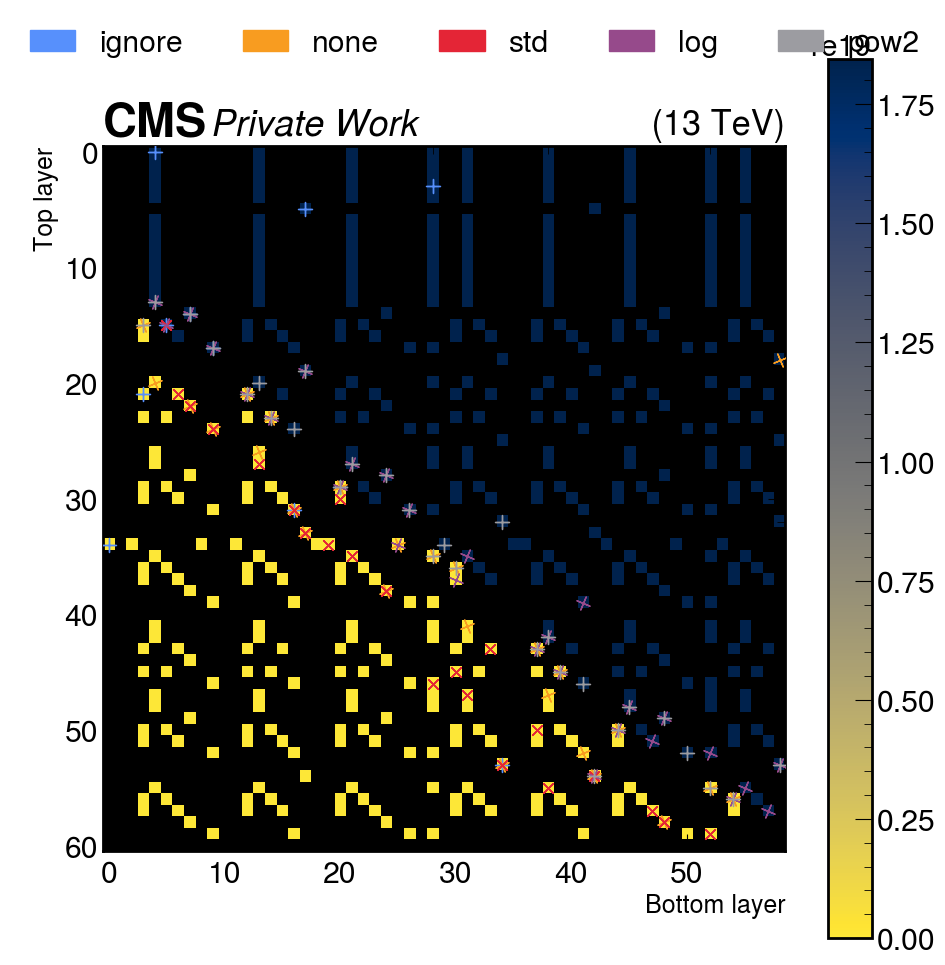

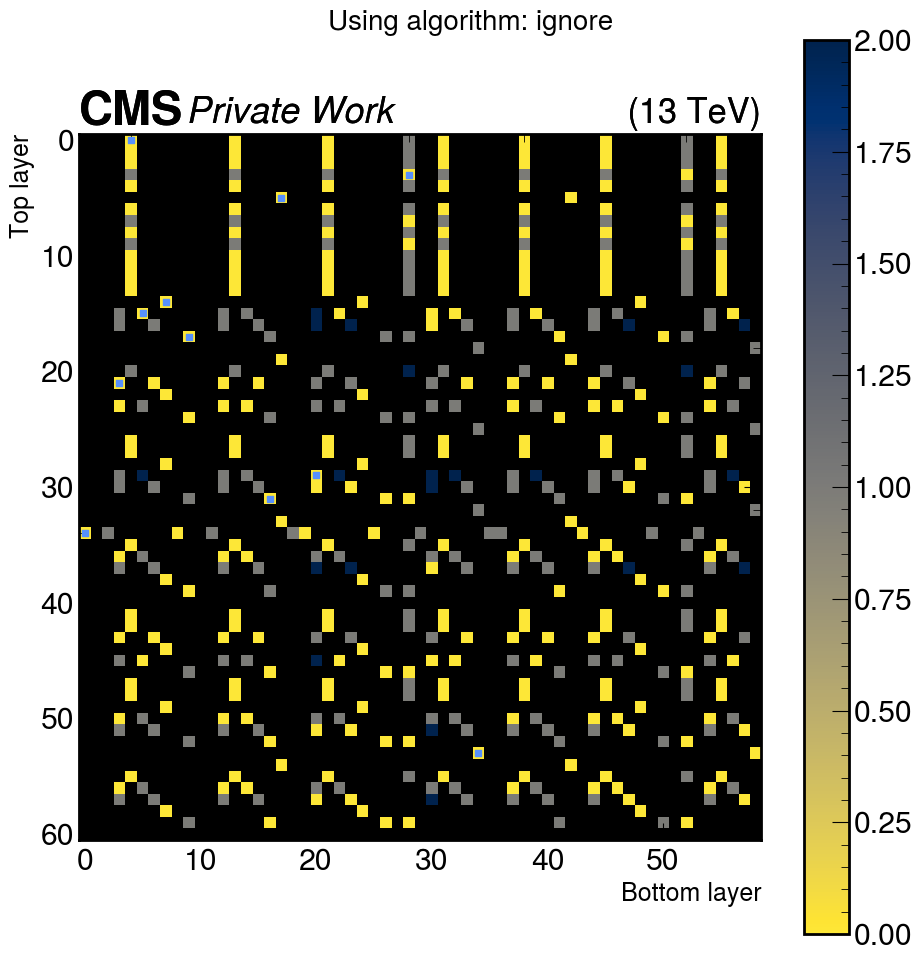

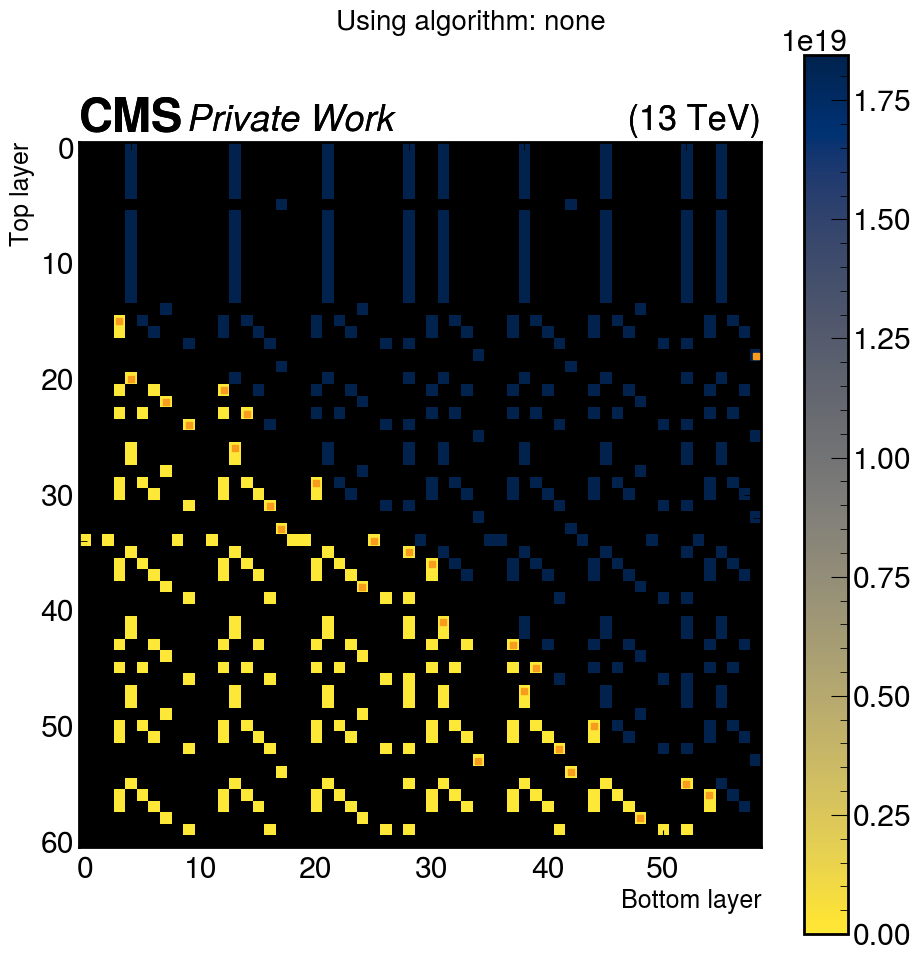

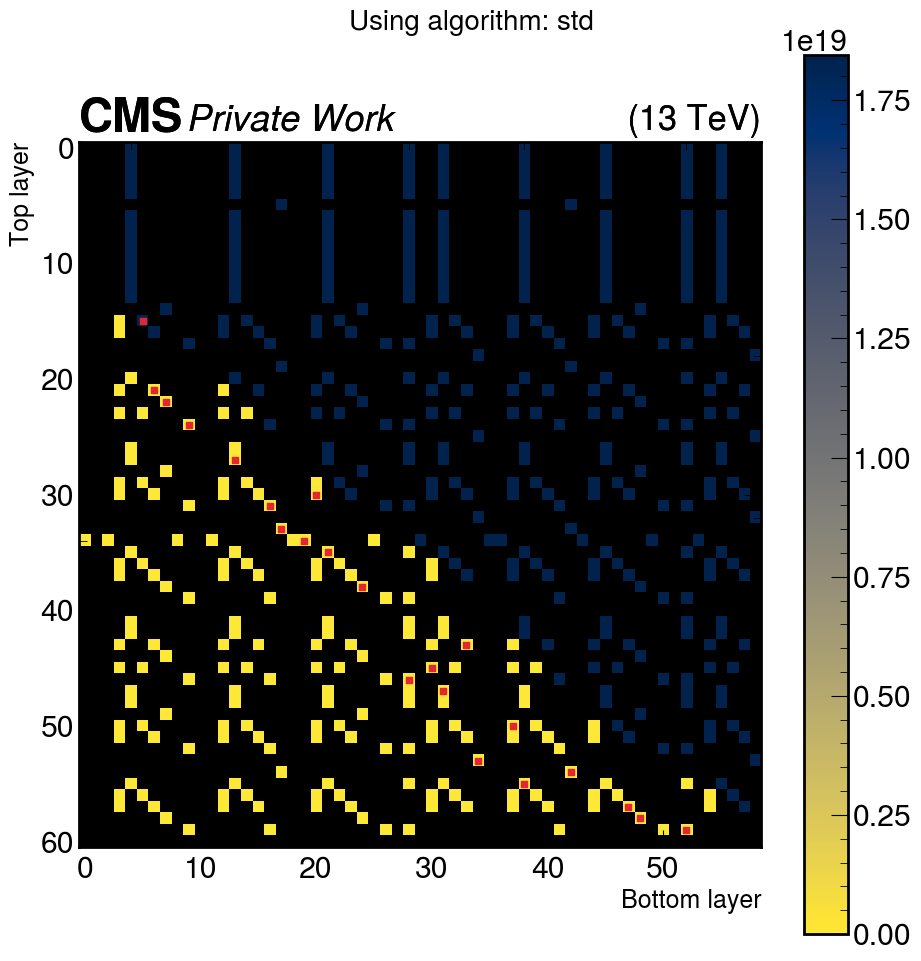

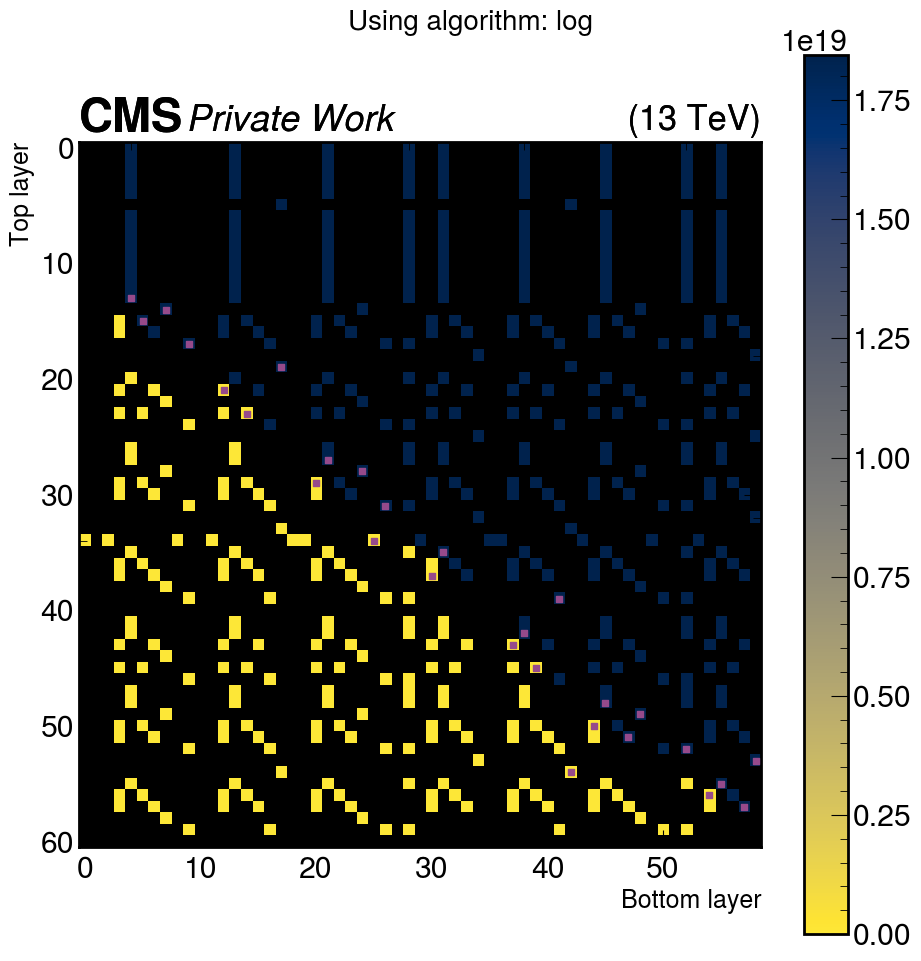

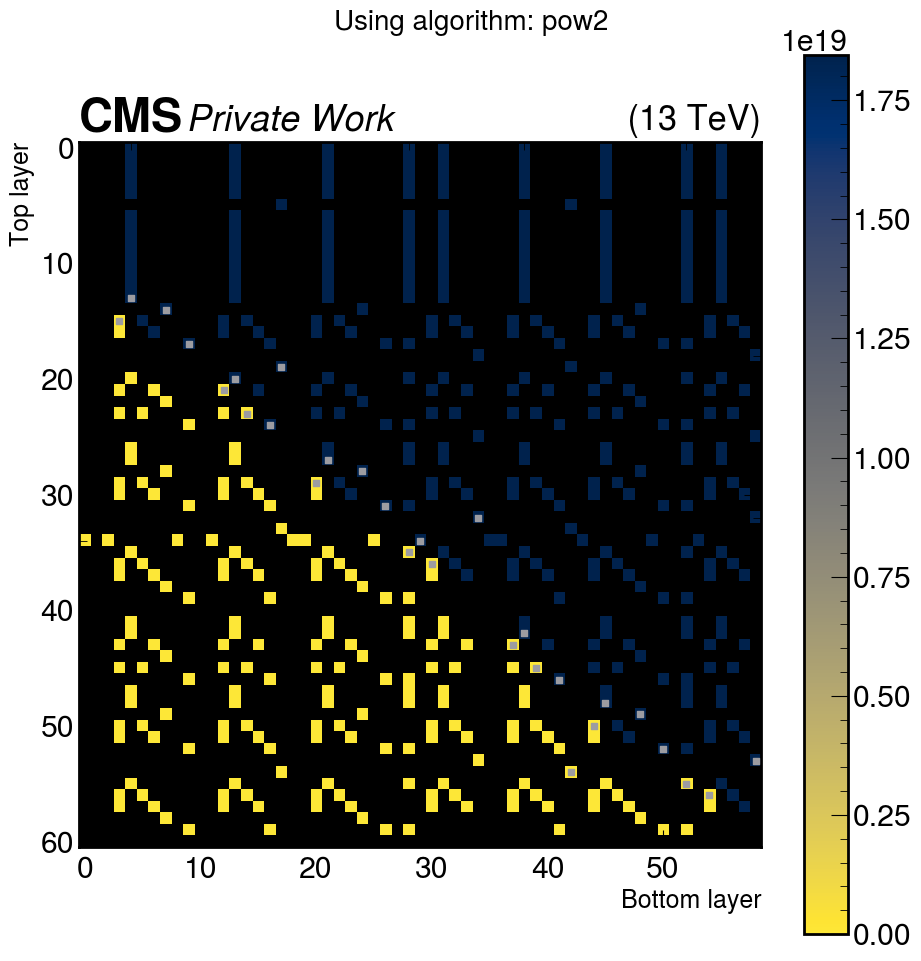

In [55]:
from dtupy_analysis.dqm.pairing.hits.pandas_backend import f_index_dict

data_ssl = mudata.get_ssl(1,1)

fig, ax = plt.subplots(1,1,figsize=(10,10))

plot_dict = {f_index : f'C{i}' for i, f_index in enumerate(f_index_dict.keys())}

msides = 4
total_diff = 0
for i, (f_index, color) in enumerate(plot_dict.items()):
    
    diff, mask = distance_matrix(data_ssl.data,1,2,f_index=f_index)
    pairs, (row_min, col_min) = get_pairs(diff, mask)

    total_diff += diff
    plot_matrix(
        np.where(mask,total_diff,np.nan),
        pairs,
        marker_scale=1,
        color=color,
        ax = ax,
        label=False,
        mangle=i*(360/msides)/(len(plot_dict)-1),
        msides=msides,
        cmap='cividis_r',
        mstyle=2
    )
    fig_i, ax_i = plt.subplots(1,1,figsize=(10,10))
    plot_matrix(
        np.where(mask,total_diff,np.nan),
        pairs, #row_min, col_min,
        ax = ax_i,
        marker_scale=.5,
        color=color,
        cmap='cividis_r',
        mangle=45
    )
    fig_i.suptitle(f'Using algorithm: {f_index}', fontsize=20)
    

fig.legend([mpl.patches.Patch(color=color) for color in plot_dict.values()], f_index_dict.keys() ,loc=2, ncols=len(f_index_dict))
fig.tight_layout()
fig.show()

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: xlabel='Bottom layer', ylabel='Top layer'>)

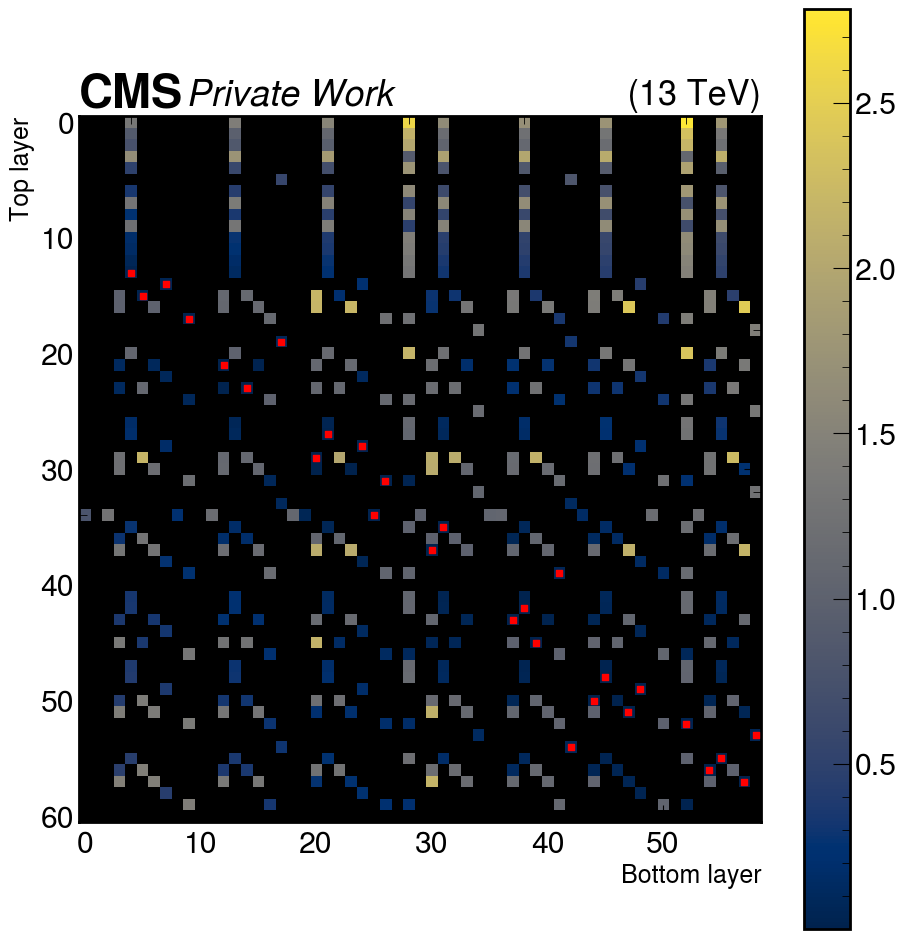

In [56]:
fig_i, ax_i = plt.subplots(1,1,figsize=(10,10))

diff, mask = distance_matrix(data_ssl.data,1,2,f_index='log')
pairs, (row_min, col_min) = get_pairs(diff, mask)

plot_matrix(
    np.where(mask,diff,np.nan),
    pairs, #row_min, col_min,
    ax = ax_i,
    marker_scale=.5,
    color='r',
    cmap='cividis',
    mangle=45
)

In [ ]:
df = pd.read_parquet(file_path.with_stem(f'{file_path.stem}').with_suffix('.seg'))

In [29]:
df.lnl = str(df.lnl)

In [32]:
df.to_parquet(file_path.with_stem(f'{file_path.stem}_seg').with_suffix('.parquet'))

In [ ]:
musl : dqm.MuSL
print('Number of pairs before yoking')
[print('', lwl, len(pairs)) for lwl, pairs in musl.pairs.items()]
musl.yoke_pairs()
print('Number of pairs after yoking')
[print('', lwl, len(pairs)) for lwl, pairs in musl.pairs.items()]
print('Number of tryads before yoking')
[print('', lwlwl, len(tryads)) for lwlwl, tryads in musl.tryads.items()]
musl.yoke_tryads()
print('Number of tryads after yoking')
[print('', lwlwl, len(tryads)) for lwlwl, tryads in musl.tryads.items()]
print('Number of tetrads after yoking')
print('', lwlwl % 4 * lwlwl, len(musl.tetrads))

In [ ]:
unyoked_pairs = deepcopy(musl.pairs)
yoked_pairs = {}
[print(f'Pairs in {lwl}', len(unyoked_pairs[lwl])) for lwl in unyoked_pairs.keys()]
throuples = {}

for lwl in musl.lwl[:-1]:
    top_j = list(unyoked_pairs[lwl  ].keys()  )
    top_i = list(unyoked_pairs[lwl  ].values())
    bot_j = list(unyoked_pairs[lwl-1].keys()  )

    idx_top, idx_bot = np.where((np.c_[top_i] - np.r_[bot_j] ) == 0)

    throuples[lwl*(lwl-1)] = {
        i : [
            top_j[m_top],
            unyoked_pairs[lwl]  .pop(top_j[m_top]),
            unyoked_pairs[lwl-1].pop(bot_j[n_bot]),
        ]
        for i, (m_top, n_bot) in enumerate(zip(idx_top, idx_bot))
    }

[print(key, len(throuple)) for key, throuple in throuples.items()]
traces = []

for lwlwl, throuple in throuples.items():
    lwl = lwlwl % 4 # gets id for missing 2-group
    if lwlwl > lwl:
        # 3-group is aligned left
        top = np.array(list(throuple.values()))[:,-1]
        bot = list(unyoked_pairs[lwl].keys())
    else:
        # 3-group is aligned right
        top = list(unyoked_pairs[lwl].values())
        bot = np.array(list(throuple.values()))[:,0]
        
    idx_top, idx_bot = np.where((np.c_[top] - np.r_[bot] ) == 0)
    for (m_top, n_bot)  in zip(idx_top, idx_bot):
        if lwlwl > lwl:
        # 3-group is aligned left
            trace = [*throuple.pop(m_top), unyoked_pairs[lwl].pop(bot[n_bot])]
        else:
        # 3-group is aligned right
            trace = [unyoked_pairs[lwl].pop(top[m_top]), *throuple.pop(n_bot)]
        traces.append(trace)

display(
    len(traces),
    [len(pairs) for lwl, pairs in unyoked_pairs.items()],
    [len(throuples) for lwlwl, throuples in throuples.items()]
)
# musl.data.loc[throuples['4w3w2'][0]]
# display(np.c_[throuples['4w3w2'][:100], throuples['3w2w1'][:100]])
# display(list(musl.pairs['4w3'].items())[idx_4w3[0]],
# list(musl.pairs['3w2'].items())[idx_3w2[0]])

In [ ]:
(dqm.classes.MuSL.LnL(4,3,2) % 4) < dqm.classes.MuSL.LnL(4,3,2)

In [ ]:
[print(f'Pairs in {lwl}', len(unyoked_pairs[lwl])) for lwl in unyoked_pairs.keys()]


In [ ]:
batch_size = 100
f_overlap = 0.5
end = musl.data.shape[0].compute()
def slice_generator(end, batch_size, f_overlap = 0):
    overlap = int(f_overlap*batch_size)
    delta = batch_size - overlap
    
    i = 0
    f = batch_size
    while i < end:
        if f > end: f = -1
        yield (i, f)
        
        if f == -1: break
        
        # Update
        i += delta
        f += delta

list(slice_generator(end, batch_size, f_overlap=.8))[:2], end

# Testing grounds

In [16]:
file_path = '/nfs/cms/martialc/DTUpgrade/data/cosmic_240904_long.parquet'
file_path = Path(file_path)


with dqm.MuFile(file_path, batch_size=1e3,f_overlap=0.3) as file:
    for batch in file:
        break

In [19]:
from dtupy_analysis.dqm.pairing.pandas_backend import matrix_diff

df_ssl = batch[(batch.station == 1) & (batch.sl == 1)]
l_i = 1
l_j = 2
d_bx    = matrix_diff(df_ssl, l_i, l_j, 'bx')                           # "This should be 0", come hits may come from a previous orbit, so not always true 
d_tdc   = matrix_diff(df_ssl, l_i, l_j, 'tdc')
if 'orbit' in df_ssl.columns:
    d_ob = matrix_diff(df_ssl, l_i, l_j, 'orbit')
else:
    d_ob = np.zeros_like(d_tdc)
d_tdct  = dqm.TDCTime(d_ob, d_bx, d_tdc)                           # We need to account for the clock reset so we use the module (32*3556) tdc times per cycle and THIS difference should be less than 32

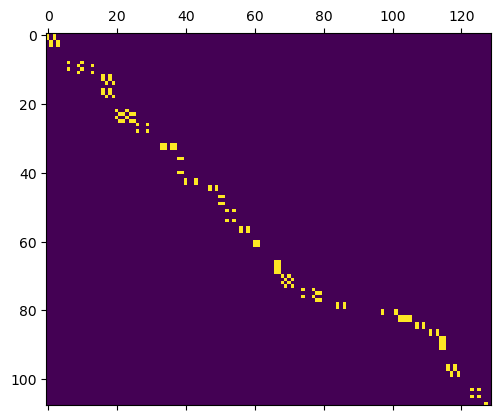

In [23]:
plt.matshow(np.abs(d_tdct.astype(int)) < 16 * u.BX_UNIT)